In [12]:
# Ignore warning messages
import warnings
warnings.filterwarnings('ignore')

In [13]:
# Import dependencies
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# Models
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from neuralprophet import NeuralProphet


In [14]:
# Read the Retail Turnover data

# Query the SQL database table populated with the data from:
# Table 1. Retail turnover, by industry group
# https://www.abs.gov.au/statistics/industry/retail-and-wholesale-trade/retail-trade-australia/latest-release#data-downloads
con = sqlite3.connect("db/ABS_RetailTurnover.db")
turnover_df = pd.read_sql_query("SELECT * from RetailTurnoverByIndustryGroup", con)
con.close()

turnover_df.head()

,RecordDate,Original__Turnover_FoodRetailing,Original__Turnover_HouseholdGoodsRetailing,Original__Turnover_ClothingFootwearAndPersonalAccessoryRetailing,Original__Turnover_DepartmentStores,Original__Turnover_OtherRetailing,Original__Turnover_CafesRestaurantsAndTakeawayFoodServices,Original__Turnover_TotalIndustry,SeasonallyAdjusted__Turnover_FoodRetailing,SeasonallyAdjusted__Turnover_HouseholdGoodsRetailing,...,SeasonallyAdjusted__Turnover_OtherRetailing,SeasonallyAdjusted__Turnover_CafesRestaurantsAndTakeawayFoodServices,SeasonallyAdjusted__Turnover_TotalIndustry,Trend__Turnover_FoodRetailing,Trend__Turnover_HouseholdGoodsRetailing,Trend__Turnover_ClothingFootwearAndPersonalAccessoryRetailing,Trend__Turnover_DepartmentStores,Trend__Turnover_OtherRetailing,Trend__Turnover_CafesRestaurantsAndTakeawayFoodServices,Trend__Turnover_TotalIndustry
0,1982-04-01,1162.6,592.3,359.9,460.1,479.1,342.4,3396.4,1167.1,653.4,...,507.9,349.8,3518.7,1173.2,652.9,362.7,482.4,505.1,347.6,3523.4
1,1982-05-01,1150.9,629.6,386.6,502.6,486.1,342.1,3497.9,1178.6,648.7,...,502.3,346.3,3527.6,1181.7,654.1,362.0,484.2,504.9,346.3,3533.6
2,1982-06-01,1160.0,607.4,350.5,443.8,467.5,328.7,3357.8,1203.7,655.7,...,506.9,350.8,3561.5,1192.7,655.6,361.9,486.4,504.7,345.9,3547.0
3,1982-07-01,1206.4,632.4,359.3,459.1,491.1,338.5,3486.8,1209.8,660.4,...,503.7,341.5,3553.9,1203.2,656.6,361.6,488.6,505.4,345.4,3560.6
4,1982-08-01,1152.5,622.6,325.2,438.4,485.7,331.5,3355.9,1198.7,659.8,...,506.0,342.7,3581.8,1213.5,656.5,361.9,489.8,505.6,346.4,3573.6


In [15]:
# Review the dataframe size to check the data was retrieved correctly 
turnover_df.shape

(509, 22)

In [16]:
# Define shorter names for the Retail Turnover categories
turnover_categories = ['Food', 'Household_Goods', 'Clothing_and_Footware', 'Department_Stores', 
                       'Other_Retailing', 'Cafes_Restaurants_TakeAway']
turnover_categories

['Food',
 'Household_Goods',
 'Clothing_and_Footware',
 'Department_Stores',
 'Other_Retailing',
 'Cafes_Restaurants_TakeAway']

In [17]:
# Focus on the Seasonally Adjusted Retail Turnover data
sa_turnover_df = turnover_df.iloc[0:, np.r_[0, 8:14]]
sa_turnover_df.columns = ['Year-Month'] + turnover_categories


In [18]:
# Convert datetime values from string to datetime type
sa_turnover_df['Year-Month'] = pd.to_datetime(sa_turnover_df['Year-Month'])


In [19]:
# Check the dataframe has record date ('Year-Month') as the first column, with turnover values in the other columns
sa_turnover_df

,Year-Month,Food,Household_Goods,Clothing_and_Footware,Department_Stores,Other_Retailing,Cafes_Restaurants_TakeAway
0,1982-04-01,1167.1,653.4,360.7,479.7,507.9,349.8
1,1982-05-01,1178.6,648.7,362.6,489.2,502.3,346.3
2,1982-06-01,1203.7,655.7,365.1,479.2,506.9,350.8
3,1982-07-01,1209.8,660.4,362.0,476.5,503.7,341.5
4,1982-08-01,1198.7,659.8,359.3,515.2,506.0,342.7
...,...,...,...,...,...,...,...
504,2024-04-01,14285.9,5689.7,2940.4,1885.1,5611.4,5398.8
505,2024-05-01,14383.1,5755.8,2980.5,1873.3,5621.1,5388.4
506,2024-06-01,14420.0,5818.8,3001.7,1889.6,5671.4,5385.6
507,2024-07-01,14447.2,5815.2,2995.3,1884.8,5679.5,5385.3


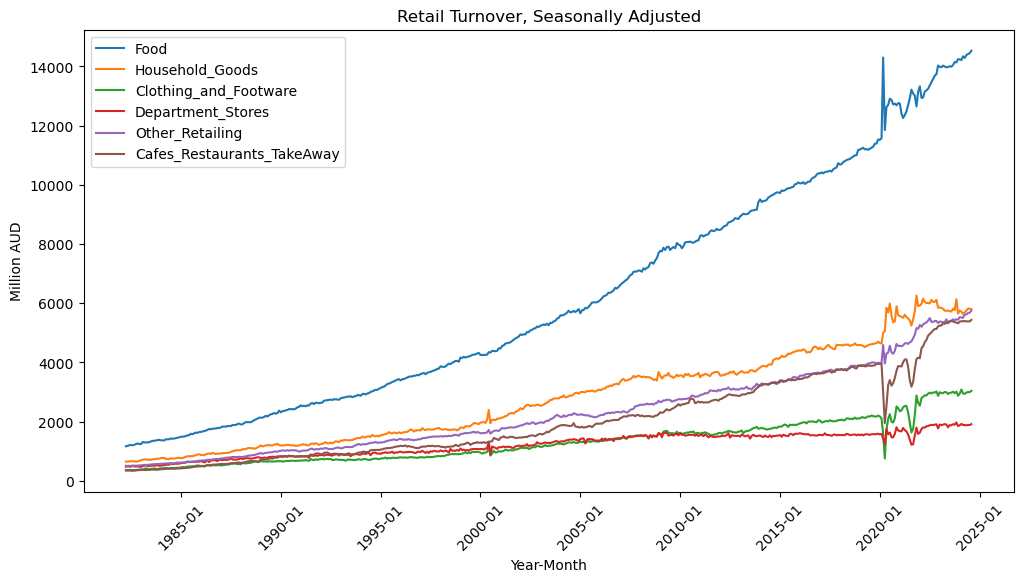

In [20]:
# Exploratory Data Analysis

# Reset the dataframe index to be the datetime column
plot_df = sa_turnover_df.copy()
plot_df.reset_index(inplace=True, drop=True)
plot_df = plot_df.set_index(['Year-Month'])

#Format visualization
figure, axes = plt.subplots(figsize=(12, 6))  # Adjust the figure size to take up more of the page
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

plt.title('Retail Turnover, Seasonally Adjusted')
plt.ylabel('Million AUD')
plt.xlabel('Year-Month')
plt.xticks(rotation=45)

plt.plot(plot_df.index, sa_turnover_df['Food'], label='Food')
plt.plot(plot_df.index, sa_turnover_df['Household_Goods'], label='Household_Goods')
plt.plot(plot_df.index, sa_turnover_df['Clothing_and_Footware'], label='Clothing_and_Footware')
plt.plot(plot_df.index, sa_turnover_df['Department_Stores'], label='Department_Stores')
plt.plot(plot_df.index, sa_turnover_df['Other_Retailing'], label='Other_Retailing')
plt.plot(plot_df.index, sa_turnover_df['Cafes_Restaurants_TakeAway'], label='Cafes_Restaurants_TakeAway')

plt.legend() 
plt.show()


# Data Analysis / Results Preparation

### Choose the Forecast period & prepare to Normalize / Scale the dataset

In [21]:
str_forecast_from_date = "2022-09-01" # This date sets up a 24 month forecast, as the dataset goes to 2024-08-01 inclusive.
forecast_from_date = pd.to_datetime(str_forecast_from_date, format='%Y-%m-%d')


In [22]:
# Initialize scaler
min_max_scaler = MinMaxScaler()

### Create placeholdersfor model performance results

In [23]:
# Initialise storage of model performance result sets

# Define a results template
results_template_df = pd.DataFrame({'Category': turnover_categories,
                                    'RMSE': np.zeros(len(turnover_categories)),
                                    'R-squared': np.zeros(len(turnover_categories))
                                   })
results_template_df.set_index('Category', drop=True, inplace=True)
results_template_df = results_template_df.transpose()

# Use the template to create storage for each model's performance results
results_arma_df = results_template_df.copy()
results_arima_df = results_template_df.copy()
results_np_df = results_template_df.copy()


# Food retailing analysis & forecasting

In [24]:
category = 'Food'

In [25]:
# Extract the Food series from the Retail Turnover dataset
category_df = sa_turnover_df[['Year-Month', category]]

### Split Dataset into Training and Testing components

In [26]:
# Split the unscaled training and testing sets (useful for plots later)

# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
unscaled_df = category_df.copy()
unscaled_df.reset_index(inplace=True, drop=True)
unscaled_df = unscaled_df.set_index(['Year-Month'])

train = unscaled_df[unscaled_df.index < forecast_from_date]
test = unscaled_df[unscaled_df.index >= forecast_from_date]

In [27]:
# Scale (normalise) the data series.

# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
scaled_df = category_df.copy()
scaled_df.reset_index(inplace=True, drop=True)
scaled_df = scaled_df.set_index(['Year-Month'])

# Scaling has to be done as a whole series, otherwise train and test splits would be normalised separately.
scaled_df[category] = min_max_scaler.fit_transform(pd.DataFrame(scaled_df[category]))


In [28]:
# Splitting the scaled data into training and testing sets
scaled_train = scaled_df[scaled_df.index < forecast_from_date]
scaled_test = scaled_df[scaled_df.index >= forecast_from_date]


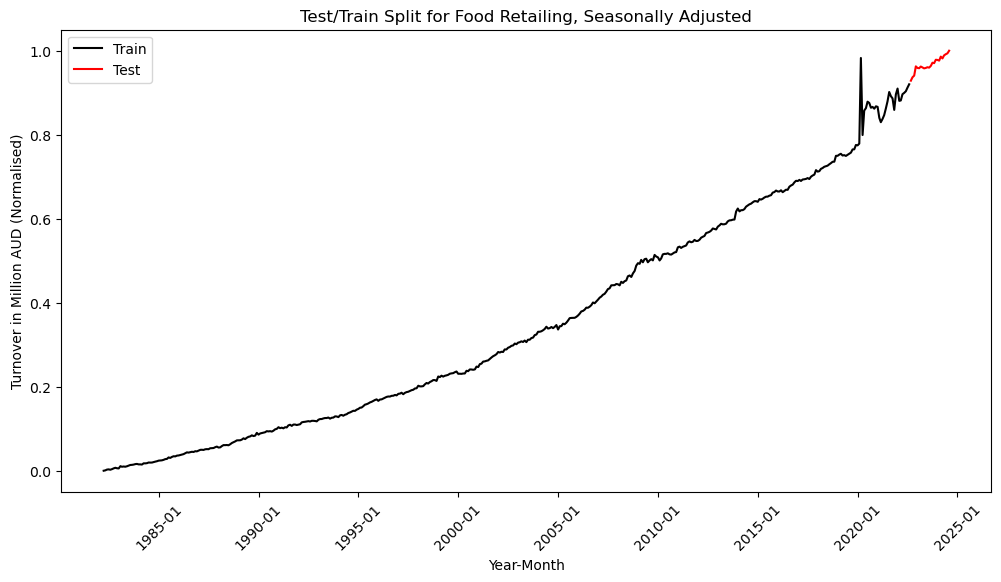

In [29]:
# Plotting the train and test sets
figure, axes = plt.subplots(figsize=(12, 6))  # Adjust the figure size to take up more of the page
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

plt.plot(scaled_train.index, scaled_train['Food'], color="black", label='Train')
plt.plot(scaled_test.index, scaled_test['Food'], color="red", label='Test')

plt.title(f"Test/Train Split for {category} Retailing, Seasonally Adjusted")
plt.ylabel('Turnover in Million AUD (Normalised)')
plt.xlabel('Year-Month')
plt.xticks(rotation=45)
plt.legend()  # Show legend to differentiate train/test
# plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

## Time series prediction - Statistical Models

## ARMA

### ARMA - Food Retail Turnover

In [30]:
# Define the model output
y = scaled_train[category]
y_label_arma = "ARMA Predictions"

# Define ARMA Model
ARMAmodel = SARIMAX(y, order=(1, 0, 1))
ARMAmodel_fit = ARMAmodel.fit(disp=False)

# Generate Turnover predictions
y_pred_arma = ARMAmodel_fit.get_forecast(len(scaled_test))
y_pred_arma_df = y_pred_arma.conf_int(alpha=0.05)
y_pred_arma_df[y_label_arma] = ARMAmodel_fit.predict(start=y_pred_arma_df.index[0], end=y_pred_arma_df.index[-1])

# Align the index with test data
y_pred_arma_df.index = scaled_test.index


In [31]:
# Unscale the results ready for plotting and model performance analysis
y_pred_arma_df[y_label_arma] = min_max_scaler.inverse_transform(pd.DataFrame(y_pred_arma_df[y_label_arma]))

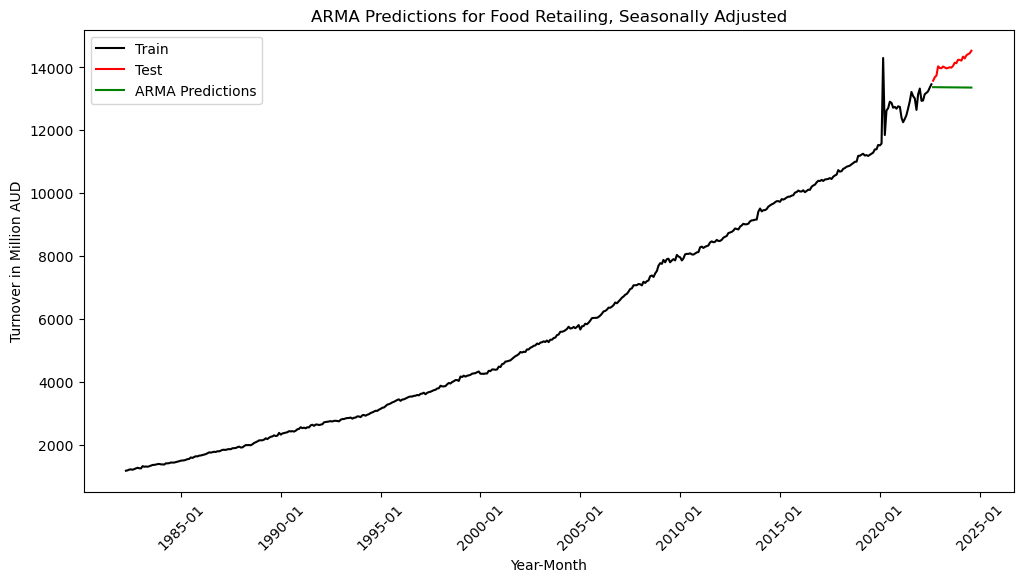

In [32]:
# Plot the Results

# Plotting the train and test data
figure, axes = plt.subplots(figsize=(12, 6))  # Adjust the figure size to take up more of the page
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.plot(train.index, train[category], label='Train', color='black')
plt.plot(test.index, test[category], label='Test', color='red')

# Plot the ARMA predictions
plt.plot(y_pred_arma_df[y_label_arma].index, y_pred_arma_df[y_label_arma], color='green', label=y_label_arma)

# Labels and Title
plt.title(f"ARMA Predictions for {category} Retailing, Seasonally Adjusted")
plt.ylabel('Turnover in Million AUD')
plt.xlabel('Year-Month')
plt.xticks(rotation=45)
plt.legend()
# plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [33]:
# Calculate and save model performance results 

# Calculate RMSE and R-squared for ARMA - Food
rmse_arma= np.sqrt(mean_squared_error(test[category].values, y_pred_arma_df[y_label_arma]))
rsqd_arma = r2_score(test[category].values, y_pred_arma_df[y_label_arma])
results_arma_df[category] = [rmse_arma, rsqd_arma]

### ARMA - repeat the analysis for other Retail Turnover categories

In [34]:
category = 'Household_Goods'

# Extract the data series from the Retail Turnover dataset
category_df = sa_turnover_df[['Year-Month', category]]

# Split the unscaled training and testing sets (useful for plots later)
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
unscaled_df = category_df.copy()
unscaled_df.reset_index(inplace=True, drop=True)
unscaled_df = unscaled_df.set_index(['Year-Month'])

train = unscaled_df[unscaled_df.index < forecast_from_date]
test = unscaled_df[unscaled_df.index >= forecast_from_date]

# Scale (normalise) the data series.
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
scaled_df = category_df.copy()
scaled_df.reset_index(inplace=True, drop=True)
scaled_df = scaled_df.set_index(['Year-Month'])

# Scaling has to be done as a whole series, otherwise train and test splits would be normalised separately.
scaled_df[category] = min_max_scaler.fit_transform(pd.DataFrame(scaled_df[category]))

# Splitting the scaled data into training and testing sets
scaled_train = scaled_df[scaled_df.index < forecast_from_date]
scaled_test = scaled_df[scaled_df.index >= forecast_from_date]

# Define the model output
y = scaled_train[category]
y_label_arma = "ARMA Predictions"

# Define ARMA Model
ARMAmodel = SARIMAX(y, order=(1, 0, 1))
ARMAmodel_fit = ARMAmodel.fit(disp=False)

# Generate Turnover predictions
y_pred_arma = ARMAmodel_fit.get_forecast(len(scaled_test))
y_pred_arma_df = y_pred_arma.conf_int(alpha=0.05)
y_pred_arma_df[y_label_arma] = ARMAmodel_fit.predict(start=y_pred_arma_df.index[0], end=y_pred_arma_df.index[-1])

# Align the index with test data
y_pred_arma_df.index = scaled_test.index

# Unscale the results ready for plotting and model performance analysis
y_pred_arma_df[y_label_arma] = min_max_scaler.inverse_transform(pd.DataFrame(y_pred_arma_df[y_label_arma]))

# Calculate and save model performance results 

# Calculate RMSE and R-squared for ARMA - Household_Goods
rmse_arma= np.sqrt(mean_squared_error(test[category].values, y_pred_arma_df[y_label_arma]))
rsqd_arma = r2_score(test[category].values, y_pred_arma_df[y_label_arma])
results_arma_df[category] = [rmse_arma, rsqd_arma]

In [35]:
category = 'Clothing_and_Footware'

# Extract the data series from the Retail Turnover dataset
category_df = sa_turnover_df[['Year-Month', category]]

# Split the unscaled training and testing sets (useful for plots later)
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
unscaled_df = category_df.copy()
unscaled_df.reset_index(inplace=True, drop=True)
unscaled_df = unscaled_df.set_index(['Year-Month'])

train = unscaled_df[unscaled_df.index < forecast_from_date]
test = unscaled_df[unscaled_df.index >= forecast_from_date]

# Scale (normalise) the data series.
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
scaled_df = category_df.copy()
scaled_df.reset_index(inplace=True, drop=True)
scaled_df = scaled_df.set_index(['Year-Month'])

# Scaling has to be done as a whole series, otherwise train and test splits would be normalised separately.
scaled_df[category] = min_max_scaler.fit_transform(pd.DataFrame(scaled_df[category]))

# Splitting the scaled data into training and testing sets
scaled_train = scaled_df[scaled_df.index < forecast_from_date]
scaled_test = scaled_df[scaled_df.index >= forecast_from_date]

# Define the model output
y = scaled_train[category]
y_label_arma = "ARMA Predictions"

# Define ARMA Model
ARMAmodel = SARIMAX(y, order=(1, 0, 1))
ARMAmodel_fit = ARMAmodel.fit(disp=False)

# Generate Turnover predictions
y_pred_arma = ARMAmodel_fit.get_forecast(len(scaled_test))
y_pred_arma_df = y_pred_arma.conf_int(alpha=0.05)
y_pred_arma_df[y_label_arma] = ARMAmodel_fit.predict(start=y_pred_arma_df.index[0], end=y_pred_arma_df.index[-1])

# Align the index with test data
y_pred_arma_df.index = scaled_test.index

# Unscale the results ready for plotting and model performance analysis
y_pred_arma_df[y_label_arma] = min_max_scaler.inverse_transform(pd.DataFrame(y_pred_arma_df[y_label_arma]))

# Calculate and save model performance results 

# Calculate RMSE and R-squared for ARMA - Household_Goods
rmse_arma= np.sqrt(mean_squared_error(test[category].values, y_pred_arma_df[y_label_arma]))
rsqd_arma = r2_score(test[category].values, y_pred_arma_df[y_label_arma])
results_arma_df[category] = [rmse_arma, rsqd_arma]

In [36]:
category = 'Department_Stores'

# Extract the data series from the Retail Turnover dataset
category_df = sa_turnover_df[['Year-Month', category]]

# Split the unscaled training and testing sets (useful for plots later)
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
unscaled_df = category_df.copy()
unscaled_df.reset_index(inplace=True, drop=True)
unscaled_df = unscaled_df.set_index(['Year-Month'])

train = unscaled_df[unscaled_df.index < forecast_from_date]
test = unscaled_df[unscaled_df.index >= forecast_from_date]

# Scale (normalise) the data series.
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
scaled_df = category_df.copy()
scaled_df.reset_index(inplace=True, drop=True)
scaled_df = scaled_df.set_index(['Year-Month'])

# Scaling has to be done as a whole series, otherwise train and test splits would be normalised separately.
scaled_df[category] = min_max_scaler.fit_transform(pd.DataFrame(scaled_df[category]))

# Splitting the scaled data into training and testing sets
scaled_train = scaled_df[scaled_df.index < forecast_from_date]
scaled_test = scaled_df[scaled_df.index >= forecast_from_date]

# Define the model output
y = scaled_train[category]
y_label_arma = "ARMA Predictions"

# Define ARMA Model
ARMAmodel = SARIMAX(y, order=(1, 0, 1))
ARMAmodel_fit = ARMAmodel.fit(disp=False)

# Generate Turnover predictions
y_pred_arma = ARMAmodel_fit.get_forecast(len(scaled_test))
y_pred_arma_df = y_pred_arma.conf_int(alpha=0.05)
y_pred_arma_df[y_label_arma] = ARMAmodel_fit.predict(start=y_pred_arma_df.index[0], end=y_pred_arma_df.index[-1])

# Align the index with test data
y_pred_arma_df.index = scaled_test.index

# Unscale the results ready for plotting and model performance analysis
y_pred_arma_df[y_label_arma] = min_max_scaler.inverse_transform(pd.DataFrame(y_pred_arma_df[y_label_arma]))

# Calculate and save model performance results 

# Calculate RMSE and R-squared for ARMA - Household_Goods
rmse_arma= np.sqrt(mean_squared_error(test[category].values, y_pred_arma_df[y_label_arma]))
rsqd_arma = r2_score(test[category].values, y_pred_arma_df[y_label_arma])
results_arma_df[category] = [rmse_arma, rsqd_arma]

In [37]:
category = 'Other_Retailing'

# Extract the data series from the Retail Turnover dataset
category_df = sa_turnover_df[['Year-Month', category]]

# Split the unscaled training and testing sets (useful for plots later)
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
unscaled_df = category_df.copy()
unscaled_df.reset_index(inplace=True, drop=True)
unscaled_df = unscaled_df.set_index(['Year-Month'])

train = unscaled_df[unscaled_df.index < forecast_from_date]
test = unscaled_df[unscaled_df.index >= forecast_from_date]

# Scale (normalise) the data series.
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
scaled_df = category_df.copy()
scaled_df.reset_index(inplace=True, drop=True)
scaled_df = scaled_df.set_index(['Year-Month'])

# Scaling has to be done as a whole series, otherwise train and test splits would be normalised separately.
scaled_df[category] = min_max_scaler.fit_transform(pd.DataFrame(scaled_df[category]))

# Splitting the scaled data into training and testing sets
scaled_train = scaled_df[scaled_df.index < forecast_from_date]
scaled_test = scaled_df[scaled_df.index >= forecast_from_date]

# Define the model output
y = scaled_train[category]
y_label_arma = "ARMA Predictions"

# Define ARMA Model
ARMAmodel = SARIMAX(y, order=(1, 0, 1))
ARMAmodel_fit = ARMAmodel.fit(disp=False)

# Generate Turnover predictions
y_pred_arma = ARMAmodel_fit.get_forecast(len(scaled_test))
y_pred_arma_df = y_pred_arma.conf_int(alpha=0.05)
y_pred_arma_df[y_label_arma] = ARMAmodel_fit.predict(start=y_pred_arma_df.index[0], end=y_pred_arma_df.index[-1])

# Align the index with test data
y_pred_arma_df.index = scaled_test.index

# Unscale the results ready for plotting and model performance analysis
y_pred_arma_df[y_label_arma] = min_max_scaler.inverse_transform(pd.DataFrame(y_pred_arma_df[y_label_arma]))

# Calculate and save model performance results 

# Calculate RMSE and R-squared for ARMA - Household_Goods
rmse_arma= np.sqrt(mean_squared_error(test[category].values, y_pred_arma_df[y_label_arma]))
rsqd_arma = r2_score(test[category].values, y_pred_arma_df[y_label_arma])
results_arma_df[category] = [rmse_arma, rsqd_arma]

In [38]:
category = 'Cafes_Restaurants_TakeAway'

# Extract the data series from the Retail Turnover dataset
category_df = sa_turnover_df[['Year-Month', category]]

# Split the unscaled training and testing sets (useful for plots later)
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
unscaled_df = category_df.copy()
unscaled_df.reset_index(inplace=True, drop=True)
unscaled_df = unscaled_df.set_index(['Year-Month'])

train = unscaled_df[unscaled_df.index < forecast_from_date]
test = unscaled_df[unscaled_df.index >= forecast_from_date]

# Scale (normalise) the data series.
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
scaled_df = category_df.copy()
scaled_df.reset_index(inplace=True, drop=True)
scaled_df = scaled_df.set_index(['Year-Month'])

# Scaling has to be done as a whole series, otherwise train and test splits would be normalised separately.
scaled_df[category] = min_max_scaler.fit_transform(pd.DataFrame(scaled_df[category]))

# Splitting the scaled data into training and testing sets
scaled_train = scaled_df[scaled_df.index < forecast_from_date]
scaled_test = scaled_df[scaled_df.index >= forecast_from_date]

# Define the model output
y = scaled_train[category]
y_label_arma = "ARMA Predictions"

# Define ARMA Model
ARMAmodel = SARIMAX(y, order=(1, 0, 1))
ARMAmodel_fit = ARMAmodel.fit(disp=False)

# Generate Turnover predictions
y_pred_arma = ARMAmodel_fit.get_forecast(len(scaled_test))
y_pred_arma_df = y_pred_arma.conf_int(alpha=0.05)
y_pred_arma_df[y_label_arma] = ARMAmodel_fit.predict(start=y_pred_arma_df.index[0], end=y_pred_arma_df.index[-1])

# Align the index with test data
y_pred_arma_df.index = scaled_test.index

# Unscale the results ready for plotting and model performance analysis
y_pred_arma_df[y_label_arma] = min_max_scaler.inverse_transform(pd.DataFrame(y_pred_arma_df[y_label_arma]))

# Calculate and save model performance results 

# Calculate RMSE and R-squared for ARMA - Household_Goods
rmse_arma= np.sqrt(mean_squared_error(test[category].values, y_pred_arma_df[y_label_arma]))
rsqd_arma = r2_score(test[category].values, y_pred_arma_df[y_label_arma])
results_arma_df[category] = [rmse_arma, rsqd_arma]

### ARMA - summarise model performance for all Turnover categories

In [39]:
results_arma_df

Category,Food,Household_Goods,Clothing_and_Footware,Department_Stores,Other_Retailing,Cafes_Restaurants_TakeAway
RMSE,772.989309,292.595682,125.613863,46.045513,138.062098,338.316832
R-squared,-9.889264,-3.791624,-6.575085,-0.524058,-0.386605,-11.686900


## ARIMA

### ARIMA - Food Retail Turnover

In [40]:
category = 'Food'

# Extract the data series from the Retail Turnover dataset
category_df = sa_turnover_df[['Year-Month', category]]

# Split the unscaled training and testing sets (useful for plots later)
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
unscaled_df = category_df.copy()
unscaled_df.reset_index(inplace=True, drop=True)
unscaled_df = unscaled_df.set_index(['Year-Month'])

train = unscaled_df[unscaled_df.index < forecast_from_date]
test = unscaled_df[unscaled_df.index >= forecast_from_date]

# Scale (normalise) the data series.
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
scaled_df = category_df.copy()
scaled_df.reset_index(inplace=True, drop=True)
scaled_df = scaled_df.set_index(['Year-Month'])

# Scaling has to be done as a whole series, otherwise train and test splits would be normalised separately.
scaled_df[category] = min_max_scaler.fit_transform(pd.DataFrame(scaled_df[category]))

# Splitting the scaled data into training and testing sets
scaled_train = scaled_df[scaled_df.index < forecast_from_date]
scaled_test = scaled_df[scaled_df.index >= forecast_from_date]

# Define the model output
y = scaled_train[category]
y_label_arima = "ARIMA Predictions"

# Define ARIMA Model
ARIMAmodel = ARIMA(y, order = (2, 2, 2)) # Adjust as necessary
ARIMAmodel_fit = ARIMAmodel.fit()

# Generate ARIMA predictions
y_pred_arima = ARIMAmodel_fit.get_forecast(len(scaled_test))
y_pred_arima_df = y_pred_arima.conf_int(alpha = 0.05) 
y_pred_arima_df[y_label_arima] = ARIMAmodel_fit.predict(start = y_pred_arima_df.index[0], end = y_pred_arima_df.index[-1])

# Align the index with test data
y_pred_arima_df.index = scaled_test.index


In [41]:
# Unscale the results ready for plotting and model performance analysis
y_pred_arima_df[y_label_arima] = min_max_scaler.inverse_transform(pd.DataFrame(y_pred_arima_df[y_label_arima]))

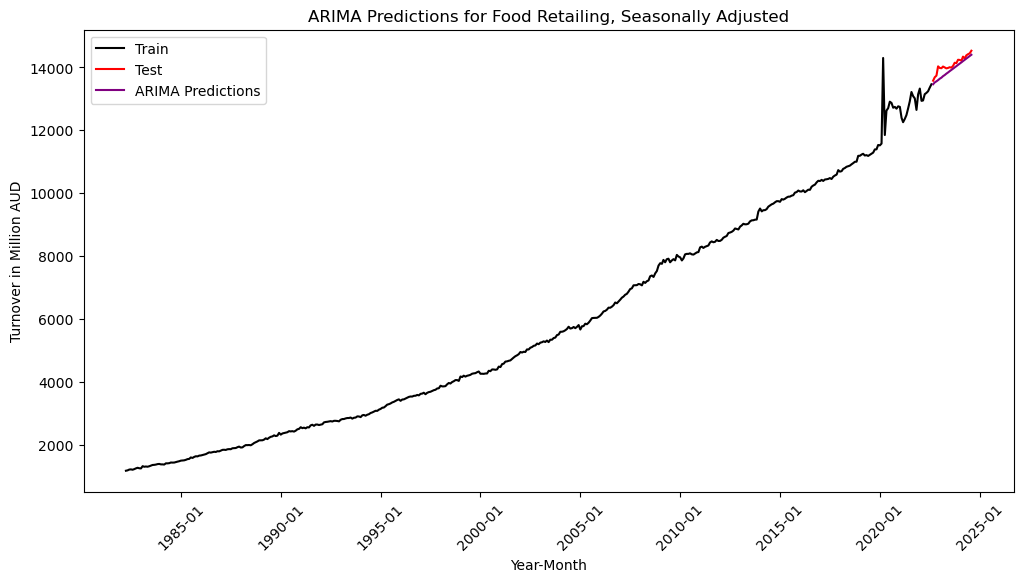

In [42]:
# Plot the Results
# Plotting the train and test sets
figure, axes = plt.subplots(figsize=(12, 6))  # Adjust the figure size to take up more of the page
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.plot(train.index, train[category], label='Train', color='black')
plt.plot(test.index, test[category], label='Test', color='red')

# Plot ARIMA Predictions
plt.plot(y_pred_arima_df.index, y_pred_arima_df[y_label_arima], color='purple', label=y_label_arima)

# Labels and Title
plt.title(f"ARIMA Predictions for {category} Retailing, Seasonally Adjusted")
plt.ylabel('Turnover in Million AUD')
plt.xlabel('Year-Month')
plt.xticks(rotation=45)
plt.legend()
# plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [43]:
# Calculate and save model performance results

# Calculate RMSE and R-squared for ARIMA
rmse_arima = np.sqrt(mean_squared_error(test[category].values, y_pred_arima_df[y_label_arima]))
rsqd_arima = r2_score(test[category].values, y_pred_arima_df[y_label_arima])
results_arima_df[category] = [rmse_arima, rsqd_arima]

### ARIMA - repeat the analysis for other Retail Turnover categories

In [44]:
category = 'Household_Goods'

# Extract the data series from the Retail Turnover dataset
category_df = sa_turnover_df[['Year-Month', category]]

# Split the unscaled training and testing sets (useful for plots later)
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
unscaled_df = category_df.copy()
unscaled_df.reset_index(inplace=True, drop=True)
unscaled_df = unscaled_df.set_index(['Year-Month'])

train = unscaled_df[unscaled_df.index < forecast_from_date]
test = unscaled_df[unscaled_df.index >= forecast_from_date]

# Scale (normalise) the data series.
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
scaled_df = category_df.copy()
scaled_df.reset_index(inplace=True, drop=True)
scaled_df = scaled_df.set_index(['Year-Month'])

# Scaling has to be done as a whole series, otherwise train and test splits would be normalised separately.
scaled_df[category] = min_max_scaler.fit_transform(pd.DataFrame(scaled_df[category]))

# Splitting the scaled data into training and testing sets
scaled_train = scaled_df[scaled_df.index < forecast_from_date]
scaled_test = scaled_df[scaled_df.index >= forecast_from_date]

# Define the model output
y = scaled_train[category]
y_label_arima = "ARIMA Predictions"

# Define ARIMA Model
ARIMAmodel = ARIMA(y, order = (2, 2, 2)) # Adjust as necessary
ARIMAmodel_fit = ARIMAmodel.fit()

# Generate ARIMA predictions
y_pred_arima = ARIMAmodel_fit.get_forecast(len(scaled_test))
y_pred_arima_df = y_pred_arima.conf_int(alpha = 0.05) 
y_pred_arima_df[y_label_arima] = ARIMAmodel_fit.predict(start = y_pred_arima_df.index[0], end = y_pred_arima_df.index[-1])

# Align the index with test data
y_pred_arima_df.index = scaled_test.index

# Unscale the results ready for plotting and model performance analysis
y_pred_arima_df[y_label_arima] = min_max_scaler.inverse_transform(pd.DataFrame(y_pred_arima_df[y_label_arima]))

# Calculate and save model performance results

# Calculate RMSE and R-squared for ARIMA
rmse_arima = np.sqrt(mean_squared_error(test[category].values, y_pred_arima_df[y_label_arima]))
rsqd_arima = r2_score(test[category].values, y_pred_arima_df[y_label_arima])
results_arima_df[category] = [rmse_arima, rsqd_arima]

In [45]:
category = 'Clothing_and_Footware'

# Extract the data series from the Retail Turnover dataset
category_df = sa_turnover_df[['Year-Month', category]]

# Split the unscaled training and testing sets (useful for plots later)
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
unscaled_df = category_df.copy()
unscaled_df.reset_index(inplace=True, drop=True)
unscaled_df = unscaled_df.set_index(['Year-Month'])

train = unscaled_df[unscaled_df.index < forecast_from_date]
test = unscaled_df[unscaled_df.index >= forecast_from_date]

# Scale (normalise) the data series.
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
scaled_df = category_df.copy()
scaled_df.reset_index(inplace=True, drop=True)
scaled_df = scaled_df.set_index(['Year-Month'])

# Scaling has to be done as a whole series, otherwise train and test splits would be normalised separately.
scaled_df[category] = min_max_scaler.fit_transform(pd.DataFrame(scaled_df[category]))

# Splitting the scaled data into training and testing sets
scaled_train = scaled_df[scaled_df.index < forecast_from_date]
scaled_test = scaled_df[scaled_df.index >= forecast_from_date]

# Define the model output
y = scaled_train[category]
y_label_arima = "ARIMA Predictions"

# Define ARIMA Model
ARIMAmodel = ARIMA(y, order = (2, 2, 2)) # Adjust as necessary
ARIMAmodel_fit = ARIMAmodel.fit()

# Generate ARIMA predictions
y_pred_arima = ARIMAmodel_fit.get_forecast(len(scaled_test))
y_pred_arima_df = y_pred_arima.conf_int(alpha = 0.05) 
y_pred_arima_df[y_label_arima] = ARIMAmodel_fit.predict(start = y_pred_arima_df.index[0], end = y_pred_arima_df.index[-1])

# Align the index with test data
y_pred_arima_df.index = scaled_test.index

# Unscale the results ready for plotting and model performance analysis
y_pred_arima_df[y_label_arima] = min_max_scaler.inverse_transform(pd.DataFrame(y_pred_arima_df[y_label_arima]))

# Calculate and save model performance results

# Calculate RMSE and R-squared for ARIMA
rmse_arima = np.sqrt(mean_squared_error(test[category].values, y_pred_arima_df[y_label_arima]))
rsqd_arima = r2_score(test[category].values, y_pred_arima_df[y_label_arima])
results_arima_df[category] = [rmse_arima, rsqd_arima]

In [46]:
category = 'Department_Stores'

# Extract the data series from the Retail Turnover dataset
category_df = sa_turnover_df[['Year-Month', category]]

# Split the unscaled training and testing sets (useful for plots later)
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
unscaled_df = category_df.copy()
unscaled_df.reset_index(inplace=True, drop=True)
unscaled_df = unscaled_df.set_index(['Year-Month'])

train = unscaled_df[unscaled_df.index < forecast_from_date]
test = unscaled_df[unscaled_df.index >= forecast_from_date]

# Scale (normalise) the data series.
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
scaled_df = category_df.copy()
scaled_df.reset_index(inplace=True, drop=True)
scaled_df = scaled_df.set_index(['Year-Month'])

# Scaling has to be done as a whole series, otherwise train and test splits would be normalised separately.
scaled_df[category] = min_max_scaler.fit_transform(pd.DataFrame(scaled_df[category]))

# Splitting the scaled data into training and testing sets
scaled_train = scaled_df[scaled_df.index < forecast_from_date]
scaled_test = scaled_df[scaled_df.index >= forecast_from_date]

# Define the model output
y = scaled_train[category]
y_label_arima = "ARIMA Predictions"

# Define ARIMA Model
ARIMAmodel = ARIMA(y, order = (2, 2, 2)) # Adjust as necessary
ARIMAmodel_fit = ARIMAmodel.fit()

# Generate ARIMA predictions
y_pred_arima = ARIMAmodel_fit.get_forecast(len(scaled_test))
y_pred_arima_df = y_pred_arima.conf_int(alpha = 0.05) 
y_pred_arima_df[y_label_arima] = ARIMAmodel_fit.predict(start = y_pred_arima_df.index[0], end = y_pred_arima_df.index[-1])

# Align the index with test data
y_pred_arima_df.index = scaled_test.index

# Unscale the results ready for plotting and model performance analysis
y_pred_arima_df[y_label_arima] = min_max_scaler.inverse_transform(pd.DataFrame(y_pred_arima_df[y_label_arima]))

# Calculate and save model performance results

# Calculate RMSE and R-squared for ARIMA
rmse_arima = np.sqrt(mean_squared_error(test[category].values, y_pred_arima_df[y_label_arima]))
rsqd_arima = r2_score(test[category].values, y_pred_arima_df[y_label_arima])
results_arima_df[category] = [rmse_arima, rsqd_arima]

In [47]:
category = 'Other_Retailing'

# Extract the data series from the Retail Turnover dataset
category_df = sa_turnover_df[['Year-Month', category]]

# Split the unscaled training and testing sets (useful for plots later)
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
unscaled_df = category_df.copy()
unscaled_df.reset_index(inplace=True, drop=True)
unscaled_df = unscaled_df.set_index(['Year-Month'])

train = unscaled_df[unscaled_df.index < forecast_from_date]
test = unscaled_df[unscaled_df.index >= forecast_from_date]

# Scale (normalise) the data series.
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
scaled_df = category_df.copy()
scaled_df.reset_index(inplace=True, drop=True)
scaled_df = scaled_df.set_index(['Year-Month'])

# Scaling has to be done as a whole series, otherwise train and test splits would be normalised separately.
scaled_df[category] = min_max_scaler.fit_transform(pd.DataFrame(scaled_df[category]))

# Splitting the scaled data into training and testing sets
scaled_train = scaled_df[scaled_df.index < forecast_from_date]
scaled_test = scaled_df[scaled_df.index >= forecast_from_date]

# Define the model output
y = scaled_train[category]
y_label_arima = "ARIMA Predictions"

# Define ARIMA Model
ARIMAmodel = ARIMA(y, order = (2, 2, 2)) # Adjust as necessary
ARIMAmodel_fit = ARIMAmodel.fit()

# Generate ARIMA predictions
y_pred_arima = ARIMAmodel_fit.get_forecast(len(scaled_test))
y_pred_arima_df = y_pred_arima.conf_int(alpha = 0.05) 
y_pred_arima_df[y_label_arima] = ARIMAmodel_fit.predict(start = y_pred_arima_df.index[0], end = y_pred_arima_df.index[-1])

# Align the index with test data
y_pred_arima_df.index = scaled_test.index

# Unscale the results ready for plotting and model performance analysis
y_pred_arima_df[y_label_arima] = min_max_scaler.inverse_transform(pd.DataFrame(y_pred_arima_df[y_label_arima]))

# Calculate and save model performance results

# Calculate RMSE and R-squared for ARIMA
rmse_arima = np.sqrt(mean_squared_error(test[category].values, y_pred_arima_df[y_label_arima]))
rsqd_arima = r2_score(test[category].values, y_pred_arima_df[y_label_arima])
results_arima_df[category] = [rmse_arima, rsqd_arima]

In [48]:
category = 'Cafes_Restaurants_TakeAway'

# Extract the data series from the Retail Turnover dataset
category_df = sa_turnover_df[['Year-Month', category]]

# Split the unscaled training and testing sets (useful for plots later)
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
unscaled_df = category_df.copy()
unscaled_df.reset_index(inplace=True, drop=True)
unscaled_df = unscaled_df.set_index(['Year-Month'])

train = unscaled_df[unscaled_df.index < forecast_from_date]
test = unscaled_df[unscaled_df.index >= forecast_from_date]

# Scale (normalise) the data series.
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
scaled_df = category_df.copy()
scaled_df.reset_index(inplace=True, drop=True)
scaled_df = scaled_df.set_index(['Year-Month'])

# Scaling has to be done as a whole series, otherwise train and test splits would be normalised separately.
scaled_df[category] = min_max_scaler.fit_transform(pd.DataFrame(scaled_df[category]))

# Splitting the scaled data into training and testing sets
scaled_train = scaled_df[scaled_df.index < forecast_from_date]
scaled_test = scaled_df[scaled_df.index >= forecast_from_date]

# Define the model output
y = scaled_train[category]
y_label_arima = "ARIMA Predictions"

# Define ARIMA Model
ARIMAmodel = ARIMA(y, order = (2, 2, 2)) # Adjust as necessary
ARIMAmodel_fit = ARIMAmodel.fit()

# Generate ARIMA predictions
y_pred_arima = ARIMAmodel_fit.get_forecast(len(scaled_test))
y_pred_arima_df = y_pred_arima.conf_int(alpha = 0.05) 
y_pred_arima_df[y_label_arima] = ARIMAmodel_fit.predict(start = y_pred_arima_df.index[0], end = y_pred_arima_df.index[-1])

# Align the index with test data
y_pred_arima_df.index = scaled_test.index

# Unscale the results ready for plotting and model performance analysis
y_pred_arima_df[y_label_arima] = min_max_scaler.inverse_transform(pd.DataFrame(y_pred_arima_df[y_label_arima]))

# Calculate and save model performance results

# Calculate RMSE and R-squared for ARIMA
rmse_arima = np.sqrt(mean_squared_error(test[category].values, y_pred_arima_df[y_label_arima]))
rsqd_arima = r2_score(test[category].values, y_pred_arima_df[y_label_arima])
results_arima_df[category] = [rmse_arima, rsqd_arima]

### ARIMA - summarise model performance for all Turnover categories

In [49]:
results_arima_df

Category,Food,Household_Goods,Clothing_and_Footware,Department_Stores,Other_Retailing,Cafes_Restaurants_TakeAway
RMSE,187.362941,511.476138,71.555975,53.478189,359.990876,164.790027
R-squared,0.360237,-13.641907,-1.458126,-1.055798,-8.427291,-2.010025


# Time series prediction - Neural Network models

## NeuralProphet

In [51]:
# Define values for NeuralProphet model hyperparameters
epochs=300

### NeuralProphet - Food Retail Turnover

In [52]:
category = 'Food'

# Extract the data series from the Retail Turnover dataset
category_df = sa_turnover_df[['Year-Month', category]]

# Split the unscaled training and testing sets (useful for plots later)
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
unscaled_df = category_df.copy()
unscaled_df.reset_index(inplace=True, drop=True)
unscaled_df = unscaled_df.set_index(['Year-Month'])

train = unscaled_df[unscaled_df.index < forecast_from_date]
test = unscaled_df[unscaled_df.index >= forecast_from_date]

# Scale (normalise) the data series.
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
scaled_df = category_df.copy()

# Scaling has to be done as a whole series, otherwise train and test splits would be normalised separately.
scaled_df[category] = min_max_scaler.fit_transform(pd.DataFrame(scaled_df[category]))

# Splitting the scaled data into training and testing sets
scaled_train = scaled_df[scaled_df['Year-Month'] < forecast_from_date]
scaled_test = scaled_df[scaled_df['Year-Month'] >= forecast_from_date]

# Prepare training and testing data in input format required by NeuralProphet
np_train = scaled_train[['Year-Month', category]].rename(columns={'Year-Month': 'ds', category: 'y'})
np_test  =  scaled_test[['Year-Month', category]].rename(columns={'Year-Month': 'ds', category: 'y'})

In [53]:
# Create and train NeuralProphet model
np_model = NeuralProphet()
metrics = np_model.fit(np_train, freq='MS', epochs=epochs)


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.794]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


Training: |                                                                                                   …

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (16) is too small than the required number                     for the learning rate finder (219). The results might not be optimal.


Finding best initial lr:   0%|          | 0/219 [00:00<?, ?it/s]

Training: |                                                                                                   …

In [57]:
# Create a blank 'future' dataframe to hold the NeuralProphet predictions for our forecast period
np_future_df = np_model.make_future_dataframe(np_train, periods=len(np_test))

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.794]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [58]:
# Calculate the forecast (predictions)
forecast = np_model.predict(np_future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [95.833]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [95.833]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: |                                                                                                 …

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [68]:
# Prepare unscaled prediction results
np_forecast_df = forecast[['ds','yhat1']]
np_forecast_df['yhat1'] = min_max_scaler.inverse_transform(pd.DataFrame(pd.DataFrame(np_forecast_df['yhat1'])))
np_forecast_df = np_forecast_df.set_index(['ds'])

In [70]:
# Create new dataframe for plotting train/test results
y_pred_np_df = np_test.copy()
y_pred_np_df = y_pred_np_df.set_index(['ds'])
y_pred_np_df = pd.concat([y_pred_np_df, np_forecast_df], axis=1)

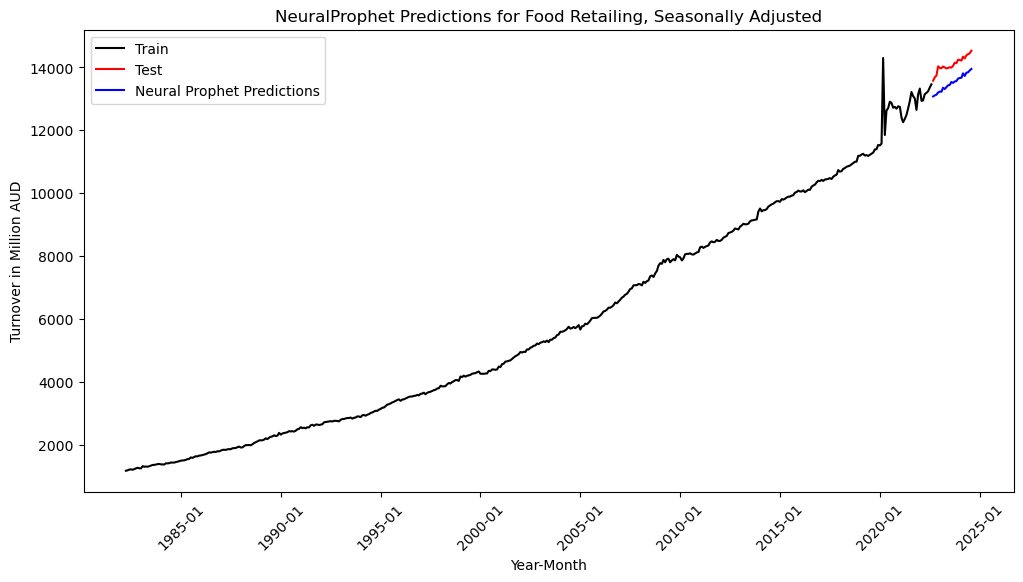

In [71]:
# Define the output
y = train[category]
y_label_np = "Neural Prophet Predictions"

# Plot the Results
# Plotting the train and test sets
figure, axes = plt.subplots(figsize=(12, 6))  # Adjust the figure size to take up more of the page
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.plot(train.index, train[category], label='Train', color='black')
plt.plot(test.index, test[category], label='Test', color='red')

# Plot the Neural Prophet predictions
plt.plot(y_pred_np_df.index, y_pred_np_df['yhat1'], color='blue', label=y_label_np)

# Labels and Title
plt.title(f'NeuralProphet Predictions for {category} Retailing, Seasonally Adjusted')
plt.ylabel('Turnover in Million AUD')
plt.xlabel('Year-Month')
plt.xticks(rotation=45)
plt.legend()
# plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [72]:
# Calculate and save model performance results

# Calculate RMSE and R-squared for NeuralProphet 
rmse_np = np.sqrt(mean_squared_error(test[category].values, y_pred_np_df['yhat1']))
rsqd_np = r2_score(test[category].values, y_pred_np_df['yhat1'])
results_np_df[category] = [rmse_np, rsqd_np]


### NeuralProphet - repeat the analysis for other Retail Turnover categories

In [73]:
category = 'Household_Goods'

# Extract the data series from the Retail Turnover dataset
category_df = sa_turnover_df[['Year-Month', category]]

# Split the unscaled training and testing sets (useful for plots later)
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
unscaled_df = category_df.copy()
unscaled_df.reset_index(inplace=True, drop=True)
unscaled_df = unscaled_df.set_index(['Year-Month'])

train = unscaled_df[unscaled_df.index < forecast_from_date]
test = unscaled_df[unscaled_df.index >= forecast_from_date]

# Scale (normalise) the data series.
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
scaled_df = category_df.copy()

# Scaling has to be done as a whole series, otherwise train and test splits would be normalised separately.
scaled_df[category] = min_max_scaler.fit_transform(pd.DataFrame(scaled_df[category]))

# Splitting the scaled data into training and testing sets
scaled_train = scaled_df[scaled_df['Year-Month'] < forecast_from_date]
scaled_test = scaled_df[scaled_df['Year-Month'] >= forecast_from_date]

# Prepare training and testing data in input format required by NeuralProphet
np_train = scaled_train[['Year-Month', category]].rename(columns={'Year-Month': 'ds', category: 'y'})
np_test  =  scaled_test[['Year-Month', category]].rename(columns={'Year-Month': 'ds', category: 'y'})

# Create and train NeuralProphet model
np_model = NeuralProphet()
metrics = np_model.fit(np_train, freq='MS', epochs=epochs)

# Create a blank 'future' dataframe to hold the NeuralProphet predictions for our forecast period
np_future_df = np_model.make_future_dataframe(np_train, periods=len(np_test))

# Calculate the forecast (predictions)
forecast = np_model.predict(np_future_df)

# Prepare unscaled prediction results
np_forecast_df = forecast[['ds','yhat1']]
np_forecast_df['yhat1'] = min_max_scaler.inverse_transform(pd.DataFrame(pd.DataFrame(np_forecast_df['yhat1'])))
np_forecast_df = np_forecast_df.set_index(['ds'])

# Create new dataframe for plotting train/test results
y_pred_np_df = np_test.copy()
y_pred_np_df = y_pred_np_df.set_index(['ds'])
y_pred_np_df = pd.concat([y_pred_np_df, np_forecast_df], axis=1)

# Calculate and save model performance results

# Calculate RMSE and R-squared for NeuralProphet 
rmse_np = np.sqrt(mean_squared_error(test[category].values, y_pred_np_df['yhat1']))
rsqd_np = r2_score(test[category].values, y_pred_np_df['yhat1'])
results_np_df[category] = [rmse_np, rsqd_np]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.794]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


Training: |                                                                                                   …

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (16) is too small than the required number                     for the learning rate finder (219). The results might not be optimal.


Finding best initial lr:   0%|          | 0/219 [00:00<?, ?it/s]

Training: |                                                                                                   …

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.794]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [95.833]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [95.833]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: |                                                                                                 …

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [74]:
category = 'Clothing_and_Footware'

# Extract the data series from the Retail Turnover dataset
category_df = sa_turnover_df[['Year-Month', category]]

# Split the unscaled training and testing sets (useful for plots later)
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
unscaled_df = category_df.copy()
unscaled_df.reset_index(inplace=True, drop=True)
unscaled_df = unscaled_df.set_index(['Year-Month'])

train = unscaled_df[unscaled_df.index < forecast_from_date]
test = unscaled_df[unscaled_df.index >= forecast_from_date]

# Scale (normalise) the data series.
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
scaled_df = category_df.copy()

# Scaling has to be done as a whole series, otherwise train and test splits would be normalised separately.
scaled_df[category] = min_max_scaler.fit_transform(pd.DataFrame(scaled_df[category]))

# Splitting the scaled data into training and testing sets
scaled_train = scaled_df[scaled_df['Year-Month'] < forecast_from_date]
scaled_test = scaled_df[scaled_df['Year-Month'] >= forecast_from_date]

# Prepare training and testing data in input format required by NeuralProphet
np_train = scaled_train[['Year-Month', category]].rename(columns={'Year-Month': 'ds', category: 'y'})
np_test  =  scaled_test[['Year-Month', category]].rename(columns={'Year-Month': 'ds', category: 'y'})

# Create and train NeuralProphet model
np_model = NeuralProphet()
metrics = np_model.fit(np_train, freq='MS', epochs=epochs)

# Create a blank 'future' dataframe to hold the NeuralProphet predictions for our forecast period
np_future_df = np_model.make_future_dataframe(np_train, periods=len(np_test))

# Calculate the forecast (predictions)
forecast = np_model.predict(np_future_df)

# Prepare unscaled prediction results
np_forecast_df = forecast[['ds','yhat1']]
np_forecast_df['yhat1'] = min_max_scaler.inverse_transform(pd.DataFrame(pd.DataFrame(np_forecast_df['yhat1'])))
np_forecast_df = np_forecast_df.set_index(['ds'])

# Create new dataframe for plotting train/test results
y_pred_np_df = np_test.copy()
y_pred_np_df = y_pred_np_df.set_index(['ds'])
y_pred_np_df = pd.concat([y_pred_np_df, np_forecast_df], axis=1)

# Calculate and save model performance results

# Calculate RMSE and R-squared for NeuralProphet 
rmse_np = np.sqrt(mean_squared_error(test[category].values, y_pred_np_df['yhat1']))
rsqd_np = r2_score(test[category].values, y_pred_np_df['yhat1'])
results_np_df[category] = [rmse_np, rsqd_np]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.794]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


Training: |                                                                                                   …

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (16) is too small than the required number                     for the learning rate finder (219). The results might not be optimal.


Finding best initial lr:   0%|          | 0/219 [00:00<?, ?it/s]

Training: |                                                                                                   …

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.794]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [95.833]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [95.833]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: |                                                                                                 …

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [75]:
category = 'Department_Stores'

# Extract the data series from the Retail Turnover dataset
category_df = sa_turnover_df[['Year-Month', category]]

# Split the unscaled training and testing sets (useful for plots later)
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
unscaled_df = category_df.copy()
unscaled_df.reset_index(inplace=True, drop=True)
unscaled_df = unscaled_df.set_index(['Year-Month'])

train = unscaled_df[unscaled_df.index < forecast_from_date]
test = unscaled_df[unscaled_df.index >= forecast_from_date]

# Scale (normalise) the data series.
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
scaled_df = category_df.copy()

# Scaling has to be done as a whole series, otherwise train and test splits would be normalised separately.
scaled_df[category] = min_max_scaler.fit_transform(pd.DataFrame(scaled_df[category]))

# Splitting the scaled data into training and testing sets
scaled_train = scaled_df[scaled_df['Year-Month'] < forecast_from_date]
scaled_test = scaled_df[scaled_df['Year-Month'] >= forecast_from_date]

# Prepare training and testing data in input format required by NeuralProphet
np_train = scaled_train[['Year-Month', category]].rename(columns={'Year-Month': 'ds', category: 'y'})
np_test  =  scaled_test[['Year-Month', category]].rename(columns={'Year-Month': 'ds', category: 'y'})

# Create and train NeuralProphet model
np_model = NeuralProphet()
metrics = np_model.fit(np_train, freq='MS', epochs=epochs)

# Create a blank 'future' dataframe to hold the NeuralProphet predictions for our forecast period
np_future_df = np_model.make_future_dataframe(np_train, periods=len(np_test))

# Calculate the forecast (predictions)
forecast = np_model.predict(np_future_df)

# Prepare unscaled prediction results
np_forecast_df = forecast[['ds','yhat1']]
np_forecast_df['yhat1'] = min_max_scaler.inverse_transform(pd.DataFrame(pd.DataFrame(np_forecast_df['yhat1'])))
np_forecast_df = np_forecast_df.set_index(['ds'])

# Create new dataframe for plotting train/test results
y_pred_np_df = np_test.copy()
y_pred_np_df = y_pred_np_df.set_index(['ds'])
y_pred_np_df = pd.concat([y_pred_np_df, np_forecast_df], axis=1)

# Calculate and save model performance results

# Calculate RMSE and R-squared for NeuralProphet 
rmse_np = np.sqrt(mean_squared_error(test[category].values, y_pred_np_df['yhat1']))
rsqd_np = r2_score(test[category].values, y_pred_np_df['yhat1'])
results_np_df[category] = [rmse_np, rsqd_np]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.794]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


Training: |                                                                                                   …

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (16) is too small than the required number                     for the learning rate finder (219). The results might not be optimal.


Finding best initial lr:   0%|          | 0/219 [00:00<?, ?it/s]

Training: |                                                                                                   …

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.794]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [95.833]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [95.833]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: |                                                                                                 …

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [76]:
category = 'Other_Retailing'

# Extract the data series from the Retail Turnover dataset
category_df = sa_turnover_df[['Year-Month', category]]

# Split the unscaled training and testing sets (useful for plots later)
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
unscaled_df = category_df.copy()
unscaled_df.reset_index(inplace=True, drop=True)
unscaled_df = unscaled_df.set_index(['Year-Month'])

train = unscaled_df[unscaled_df.index < forecast_from_date]
test = unscaled_df[unscaled_df.index >= forecast_from_date]

# Scale (normalise) the data series.
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
scaled_df = category_df.copy()

# Scaling has to be done as a whole series, otherwise train and test splits would be normalised separately.
scaled_df[category] = min_max_scaler.fit_transform(pd.DataFrame(scaled_df[category]))

# Splitting the scaled data into training and testing sets
scaled_train = scaled_df[scaled_df['Year-Month'] < forecast_from_date]
scaled_test = scaled_df[scaled_df['Year-Month'] >= forecast_from_date]

# Prepare training and testing data in input format required by NeuralProphet
np_train = scaled_train[['Year-Month', category]].rename(columns={'Year-Month': 'ds', category: 'y'})
np_test  =  scaled_test[['Year-Month', category]].rename(columns={'Year-Month': 'ds', category: 'y'})

# Create and train NeuralProphet model
np_model = NeuralProphet()
metrics = np_model.fit(np_train, freq='MS', epochs=epochs)

# Create a blank 'future' dataframe to hold the NeuralProphet predictions for our forecast period
np_future_df = np_model.make_future_dataframe(np_train, periods=len(np_test))

# Calculate the forecast (predictions)
forecast = np_model.predict(np_future_df)

# Prepare unscaled prediction results
np_forecast_df = forecast[['ds','yhat1']]
np_forecast_df['yhat1'] = min_max_scaler.inverse_transform(pd.DataFrame(pd.DataFrame(np_forecast_df['yhat1'])))
np_forecast_df = np_forecast_df.set_index(['ds'])

# Create new dataframe for plotting train/test results
y_pred_np_df = np_test.copy()
y_pred_np_df = y_pred_np_df.set_index(['ds'])
y_pred_np_df = pd.concat([y_pred_np_df, np_forecast_df], axis=1)

# Calculate and save model performance results

# Calculate RMSE and R-squared for NeuralProphet 
rmse_np = np.sqrt(mean_squared_error(test[category].values, y_pred_np_df['yhat1']))
rsqd_np = r2_score(test[category].values, y_pred_np_df['yhat1'])
results_np_df[category] = [rmse_np, rsqd_np]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.794]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


Training: |                                                                                                   …

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (16) is too small than the required number                     for the learning rate finder (219). The results might not be optimal.


Finding best initial lr:   0%|          | 0/219 [00:00<?, ?it/s]

Training: |                                                                                                   …

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.794]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [95.833]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [95.833]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: |                                                                                                 …

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [77]:
category = 'Cafes_Restaurants_TakeAway'

# Extract the data series from the Retail Turnover dataset
category_df = sa_turnover_df[['Year-Month', category]]

# Split the unscaled training and testing sets (useful for plots later)
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
unscaled_df = category_df.copy()
unscaled_df.reset_index(inplace=True, drop=True)
unscaled_df = unscaled_df.set_index(['Year-Month'])

train = unscaled_df[unscaled_df.index < forecast_from_date]
test = unscaled_df[unscaled_df.index >= forecast_from_date]

# Scale (normalise) the data series.
# Use a copy of the category data and reset the dataframe index to be the datetime column (makes for easier splitting)
scaled_df = category_df.copy()

# Scaling has to be done as a whole series, otherwise train and test splits would be normalised separately.
scaled_df[category] = min_max_scaler.fit_transform(pd.DataFrame(scaled_df[category]))

# Splitting the scaled data into training and testing sets
scaled_train = scaled_df[scaled_df['Year-Month'] < forecast_from_date]
scaled_test = scaled_df[scaled_df['Year-Month'] >= forecast_from_date]

# Prepare training and testing data in input format required by NeuralProphet
np_train = scaled_train[['Year-Month', category]].rename(columns={'Year-Month': 'ds', category: 'y'})
np_test  =  scaled_test[['Year-Month', category]].rename(columns={'Year-Month': 'ds', category: 'y'})

# Create and train NeuralProphet model
np_model = NeuralProphet()
metrics = np_model.fit(np_train, freq='MS', epochs=epochs)

# Create a blank 'future' dataframe to hold the NeuralProphet predictions for our forecast period
np_future_df = np_model.make_future_dataframe(np_train, periods=len(np_test))

# Calculate the forecast (predictions)
forecast = np_model.predict(np_future_df)

# Prepare unscaled prediction results
np_forecast_df = forecast[['ds','yhat1']]
np_forecast_df['yhat1'] = min_max_scaler.inverse_transform(pd.DataFrame(pd.DataFrame(np_forecast_df['yhat1'])))
np_forecast_df = np_forecast_df.set_index(['ds'])

# Create new dataframe for plotting train/test results
y_pred_np_df = np_test.copy()
y_pred_np_df = y_pred_np_df.set_index(['ds'])
y_pred_np_df = pd.concat([y_pred_np_df, np_forecast_df], axis=1)

# Calculate and save model performance results

# Calculate RMSE and R-squared for NeuralProphet 
rmse_np = np.sqrt(mean_squared_error(test[category].values, y_pred_np_df['yhat1']))
rsqd_np = r2_score(test[category].values, y_pred_np_df['yhat1'])
results_np_df[category] = [rmse_np, rsqd_np]


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.794]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


Training: |                                                                                                   …

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (16) is too small than the required number                     for the learning rate finder (219). The results might not be optimal.


Finding best initial lr:   0%|          | 0/219 [00:00<?, ?it/s]

Training: |                                                                                                   …

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.794]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [95.833]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [95.833]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: |                                                                                                 …

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


### NeuralProphet - summarise model performance for all Turnover categories

In [78]:
results_np_df

Category,Food,Household_Goods,Clothing_and_Footware,Department_Stores,Other_Retailing,Cafes_Restaurants_TakeAway
RMSE,602.736023,236.609438,433.562349,244.886751,493.045695,998.397975
R-squared,-5.620730,-2.133365,-89.243405,-42.107966,-16.683910,-109.488142


# Summarise Model Performance by Retail Turnover category - tables

### ARMA

In [80]:
results_arma_df

Category,Food,Household_Goods,Clothing_and_Footware,Department_Stores,Other_Retailing,Cafes_Restaurants_TakeAway
RMSE,772.989309,292.595682,125.613863,46.045513,138.062098,338.316832
R-squared,-9.889264,-3.791624,-6.575085,-0.524058,-0.386605,-11.686900


### ARIMA

In [81]:
results_arima_df

Category,Food,Household_Goods,Clothing_and_Footware,Department_Stores,Other_Retailing,Cafes_Restaurants_TakeAway
RMSE,187.362941,511.476138,71.555975,53.478189,359.990876,164.790027
R-squared,0.360237,-13.641907,-1.458126,-1.055798,-8.427291,-2.010025


### NeuralProphet

In [82]:
results_np_df

Category,Food,Household_Goods,Clothing_and_Footware,Department_Stores,Other_Retailing,Cafes_Restaurants_TakeAway
RMSE,602.736023,236.609438,433.562349,244.886751,493.045695,998.397975
R-squared,-5.620730,-2.133365,-89.243405,-42.107966,-16.683910,-109.488142
